# MCMC Produciton Data Analysis with Arps, THM and Jacobi Theta Function Model 
### Rui Kou, Apr, 2019
#### Step 0: Import the basic packages

In [1]:
import pandas
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
plt.style.use('ggplot')
%matplotlib inline

#### Step 1： Read production data from CSV file （Drillinginfo output）

In [2]:
#Extract api, monthly_oil and date from Drillinginfo File
df = pandas.read_csv('Monthly_Production.CSV')
oil = np.array(df['Monthly Oil'].values)
api_well = np.array(df['API/UWI'].values)
pro_month = np.array(df['Monthly Production Date'].values)
unique_ids=len(np.unique(api_well))
# Confirming all 153 wells are read into memory
print('Total number of wells are: {}'.format (unique_ids)) 

Total number of wells are: 153


#### Read each individual well's production data into an array
  * Chose a well, and plot the original production data
  * Take first 12 month of log(oil rate) as training data

In [3]:
ID_0 = api_well[0]
i=0
j=0
k=0
oil_array=np.zeros((unique_ids,36),dtype=int)
for ID in api_well:
    if ID==ID_0:
        oil_array[i,j]=oil[k]
        j=j+1
    else:
        ID_0=ID
        i=i+1
        j=0
    k=k+1 

#### In this case, we chose well #150, the user can choose any random well

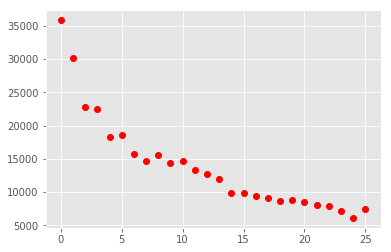

In [6]:
cur = oil_array[7]
rec_month = np.count_nonzero(cur)
plt.plot(cur[:rec_month],'ro')

#### plot the first 12 month as training data

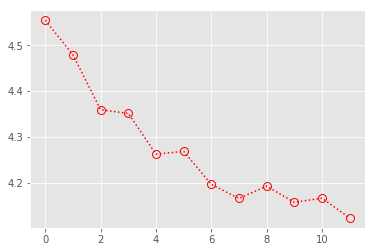

In [7]:
data = np.log10(cur[0:12])
marker_style = dict(color='r', linestyle=':', marker='o',
                    markersize=8, markerfacecoloralt='gray')
plt.plot(data,fillstyle='none',**marker_style)

# Section 1
# In this section, we implement the MCMC Arps model
####  1. Define Arps equation and get best estimate using least square residual. 
-  Plot data, initial guess and best estimate

In [8]:
def Arps(t,Di,logQi,b):
    Qt = logQi - 1/b*np.log10(1+b*Di*t)
    return Qt

In [9]:
Di = 0.5
logQi = 4
b = 0.5
t = np.linspace(0,11,12)
y_init =  Arps(t,Di,logQi,b)
params, params_covariance = optimize.curve_fit(Arps, t, data,
                                               p0=[0.22,4.3,2])
y_hat = Arps(t,params[0],params[1],params[2])
sigma = np.sqrt(np.sum(np.power(data-y_hat,2))/(len(data)-3))

print('The best estimate are: \n Di = {}\n log(Qi) = {}\n b = {}'.format(params[0],params[1],params[2]))
print('Variance is {}'.format(sigma))

The best estimate are: 
 Di = 0.360589738558525
 log(Qi) = 4.563803782420842
 b = 2.2705705058444425
Variance is 0.02487316937430861


#### The plot below shows the initial guess (blue line) is random, which is far away from best (least square) estimate

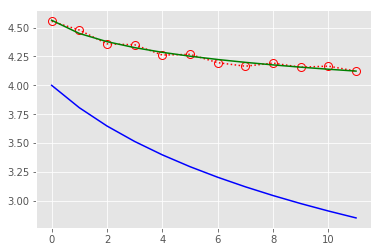

In [10]:
plt.plot(y_init,'b-') # initial guess
plt.plot(data,fillstyle='none',**marker_style)
plt.plot(y_hat,'g-')

#### 2. MCMC for parameter estimation
  * Define posterior function
  * Initialize the chain
  * Sampling from posterior distribution

In [11]:
def post(Di,logQi,b,sigma,t,data):
    like = np.prod(np.exp(-np.power(Arps(t,Di,logQi,b)-data, 2)/sigma**2))
    return like # because constant uniform prior

In [12]:
logQi = data[0]
Niter = 100000
chain = np.zeros((Niter,3))
chain[0,0] = Di # Initialize the chain with first guess
chain[0,1] = logQi
chain[0,2] = b

In [13]:
for ii in np.arange(Niter-1):
        if ii%10000 ==0:
            print('iteration {}'.format(ii))
        Di    = chain[ii,0] 
        logQi = chain[ii,1] 
        b     = chain[ii,2] 
        #sigma = chain[ii,3]
        Di_p    = Di + np.random.normal(loc=0.0,scale=0.1,size=1)
        logQi_p = logQi + np.random.normal(loc=0.0,scale=0.1,size=1)
        b_p     = b + np.random.normal(loc=0.0,scale=0.1,size=1)
        
        if Di_p < 0.1 or Di_p>50 or b_p<0 or b_p>=2 or logQi > 1000000 or logQi<0.01:
            chain[ii+1,:] = chain[ii,:]
        elif (post(Di_p,logQi_p,b_p,sigma,t,data) / post(Di,logQi,b,sigma,t,data)) > np.random.uniform():
            chain[ii+1,0] = Di_p 
            chain[ii+1,1] = logQi_p 
            chain[ii+1,2] = b_p 
        else:
            chain[ii+1,:] = chain[ii,:]
print('Sampling finished at iteration {}'.format(Niter)) 

iteration 0


/Users/weibing/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  
/Users/weibing/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in double_scalars
  


iteration 10000
iteration 20000
iteration 30000
iteration 40000
iteration 50000
iteration 60000
iteration 70000
iteration 80000
iteration 90000
Sampling finished at iteration 100000


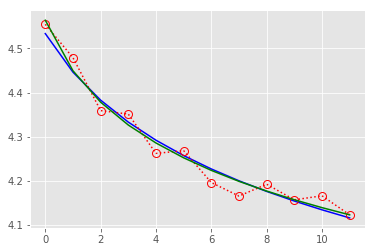

In [14]:
y_theta =  Arps(t,Di,logQi,b)
plt.plot(y_theta,'b-')
plt.plot(data,'ro',fillstyle='none',**marker_style)
plt.plot(y_hat,'g-')

#### Check Mixing of the chain, it shows good convergence

(100000, 3)

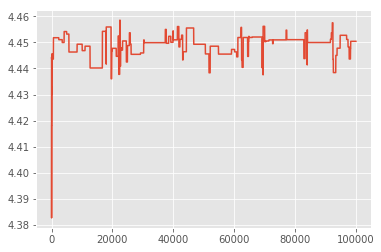

In [23]:
plt.plot(chain[:,1])
chain.shape

#### Plot the last 1000 samples from the posterios

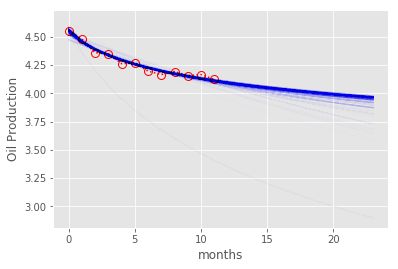

In [15]:
t_test = np.linspace(0,23,24)
chains_to_plot=np.arange(1000)*9

fig = plt.figure()
aa = plt.axes()
aa.plot(data,'ro',fillstyle='none',**marker_style)
#aa.plot(y_hat,'g-')
kk=0
qq=np.zeros([len(chains_to_plot),24])
for ii in chains_to_plot:
    qq[kk,:]=Arps(t_test,chain[ii,0],chain[ii,1],chain[ii,2])
    aa.plot(qq[kk,:],color='blue',alpha=0.002)
    kk+=1
    aa.set(xlabel='months', ylabel='Oil Production')

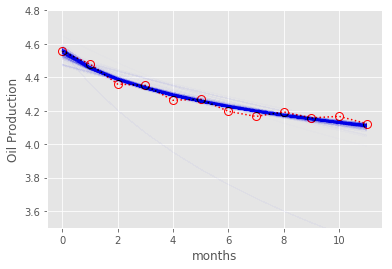

In [18]:
t_test = np.linspace(0,23,24)
chains_to_plot=np.arange(1000)*9

fig = plt.figure()
aa = plt.axes()
aa.plot(data,'ro',fillstyle='none',**marker_style)
aa.set_ylim([3.5,4.8])
#aa.plot(y_hat,'g-')
kk=0
qq=np.zeros([len(chains_to_plot),12])
for ii in chains_to_plot:
    qq[kk,:]=Arps(t,chain[ii,0],chain[ii,1],chain[ii,2])
    aa.plot(qq[kk,:],color='blue',alpha=0.002)
    kk+=1
    aa.set(xlabel='months', ylabel='Oil Production')

#### Posterior Summary, the Di, log(Qi), and b parameters

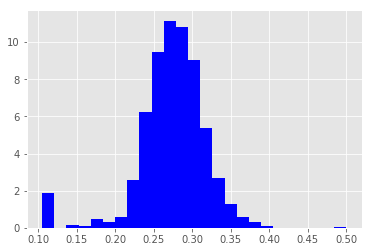

In [15]:
fig = plt.figure()
ax = plt.axes()
rectangles = ax.hist(chain[:,0],25,density=True,color='blue')

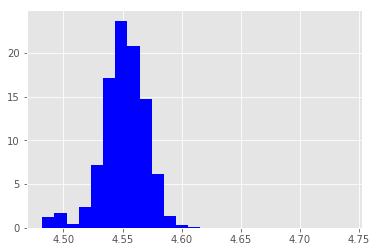

In [16]:
fig = plt.figure()
ax = plt.axes()
rectangles = ax.hist(chain[:,1],25,density=True,color='blue')

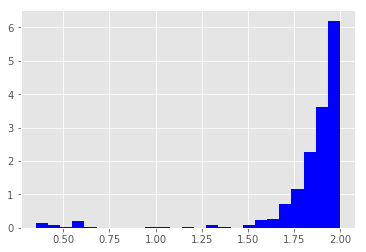

In [17]:
fig = plt.figure()
ax = plt.axes()
rectangles = ax.hist(chain[:,2],25,density=True,color='blue')

#### 3. Plot of 12month training data, 12-24 month testing data and p10-p90 interval

/Users/weibing/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log10
  app.launch_new_instance()


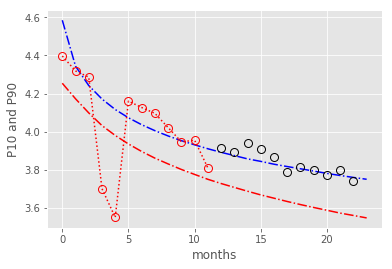

In [122]:
qq_p10=np.zeros(24)
qq_p90=np.zeros(24)
for tt in np.arange(0,24):
    sorted_qq=np.sort(qq[:,tt])
    ixL = np.floor(np.size(sorted_qq)*0.1).astype(int) ## lower index
    ixU = np.floor(np.size(sorted_qq)*0.9).astype(int) ## upper index
    qq_p10[tt]=sorted_qq[ixL]
    qq_p90[tt]=sorted_qq[ixU]

fig = plt.figure()
aa = plt.axes()
aa.plot(qq_p10,'r-.')
aa.plot(qq_p90,'b-.')
aa.set(xlabel='months', ylabel='P10 and P90');
aa.plot(data,'ro',fillstyle='none',**marker_style)
aa.plot(np.linspace(12,23,12),np.log10(cur[12:24]),'ko',fillstyle='none',markersize=8 )

# Section 2
# In this section, we implement  MCMC parameter estimation for the Transient Hyperbolic Model proposed by David Fulfor and Dr. Blasingame

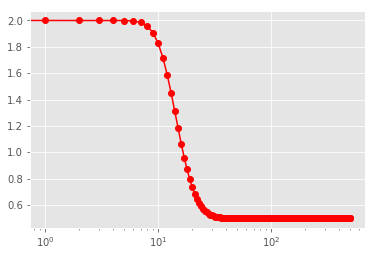

In [19]:
# First we plot one example of THM model to see its behavior
t_elf = 12
bf = 0.5
t_test = np.linspace(0,1000,500)
c = np.exp(0.57722)/(1.175*t_elf)
b = 2-(2-bf)*np.exp(-np.exp(-c*(t_test-t_elf)+np.exp(0.57722)))
plt.semilogx(b,'ro-')

#### We define the posterior probability function based on changing b parameter

In [20]:
def post(Di,logQi,bf,t_elf,sigma,t,data):
    c = np.exp(0.57722)/(1.175*t_elf)
    b = 2-(2-bf)*np.exp(-np.exp(-c*(t-t_elf)+np.exp(0.57722)))
    like = np.prod(np.exp(-np.power(Arps(t,Di,logQi,b)-data, 2)/sigma**2))
    return like # because constant uniform prior

In [21]:
logQi = data[0]
bf = 0.5
t_elf = 24
Niter = 100000
chain = np.zeros((Niter,4))
chain[0,0] = Di # Initialize the chain with first guess
chain[0,1] = logQi
chain[0,2] = bf 
chain[0,3] = t_elf

In [22]:
for ii in np.arange(Niter-1):
        if ii%10000 ==0:
            print('iteration {}'.format(ii))
        Di    = chain[ii,0] 
        logQi = chain[ii,1] 
        bf    = chain[ii,2] 
        t_elf = chain[ii,3]
        Di_p    = Di + np.random.normal(loc=0.0,scale=0.1,size=1)
        logQi_p = logQi + np.random.normal(loc=0.0,scale=0.1,size=1)
        bf_p    = bf + np.random.normal(loc=0.0,scale=0.1,size=1)
        t_elf_p = t_elf + np.random.normal(loc=0.0,scale=0.1,size=1)
        
        if Di_p < 0.1 or Di_p>50 or bf_p<0 or bf_p>1 or t_elf_p<0 or logQi > 1000000 or logQi<0.01:
            chain[ii+1,:] = chain[ii,:]
        elif (post(Di_p,logQi_p,bf_p,t_elf_p,sigma,t,data) / post(Di,logQi,bf,t_elf,sigma,t,data)) > np.random.uniform():
            chain[ii+1,0] = Di_p 
            chain[ii+1,1] = logQi_p 
            chain[ii+1,2] = bf_p
            chain[ii+1,3] = t_elf_p
        else:
            chain[ii+1,:] = chain[ii,:]
print('Sampling finished at iteration {}'.format(Niter))

iteration 0
iteration 10000
iteration 20000
iteration 30000
iteration 40000
iteration 50000
iteration 60000
iteration 70000
iteration 80000
iteration 90000
Sampling finished at iteration 100000


#### From the converged Markov Chain, we plot one sample THM decline curve vs the least square estimate
-  it shows the "end of linear flow time" is about 25 month

bf is: 0.9408030194889864
t_elf is: 31.398542442736602


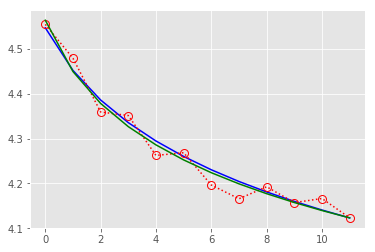

In [23]:
c = np.exp(0.57722)/(1.175*t_elf)
b = 2-(2-bf)*np.exp(-np.exp(-c*(t-t_elf)+np.exp(0.57722)))
y_theta =  Arps(t,Di,logQi,b)
plt.plot(y_theta,'b-')
plt.plot(data,'ro',fillstyle='none',**marker_style)
plt.plot(y_hat,'g-');
print('bf is: {}\nt_elf is: {}'.format(bf,t_elf))

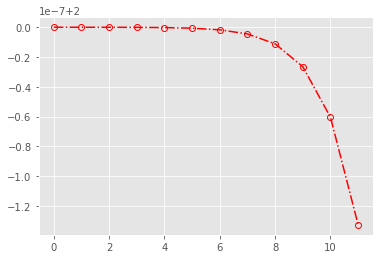

In [24]:
# plot the b parameter
plt.plot(b,'ro-.', fillstyle='none')

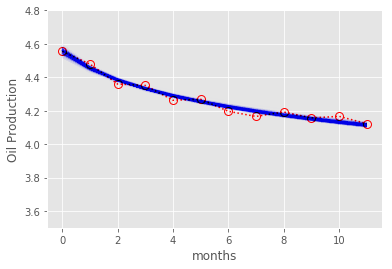

In [25]:
chains_to_plot=np.arange(1000)*9

fig = plt.figure()
aa = plt.axes()
aa.plot(data,'ro',fillstyle='none',**marker_style)
aa.set_ylim([3.5,4.8])
#aa.plot(y_hat,'g-')
kk=0
qq=np.zeros([len(chains_to_plot),len(t)])
for ii in chains_to_plot:
    b = 2-(2-chain[ii,2])*np.exp(-np.exp(-c*(t-chain[ii,3])+np.exp(0.57722)))
    qq[kk,:]=Arps(t,chain[ii,0],chain[ii,1],b)
    aa.plot(qq[kk,:],color='blue',alpha=0.002)
    kk+=1
    aa.set(xlabel='months', ylabel='Oil Production')

#### Posterior parameter distribution of 
- Di 
- log(Qi)
- b_final
- end of linear flow time (t_elf)

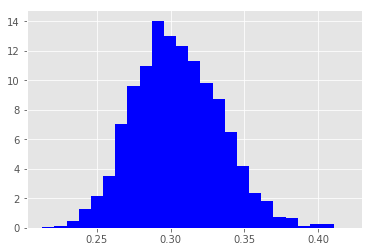

In [46]:
fig = plt.figure()
ax = plt.axes()
rectangles = ax.hist(chain[:,0],25,density=True,color='blue')

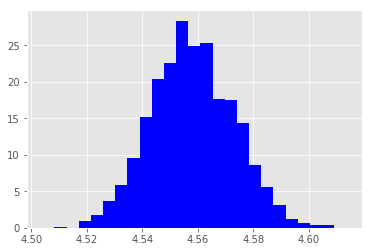

In [48]:
fig = plt.figure()
ax = plt.axes()
rectangles = ax.hist(chain[:,1],25,density=True,color='blue')

#### It shows below that b_final is evenly possible for any value between 0-1. This is because the production data is only 12 month, it didn't reach end of linear flow yet. So no estimation on the b_final

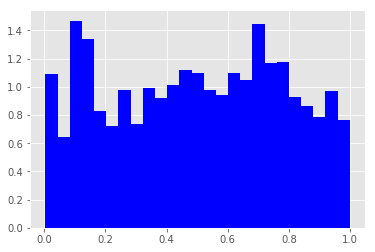

In [49]:
fig = plt.figure()
ax = plt.axes()
rectangles = ax.hist(chain[:,2],25,density=True,color='blue')

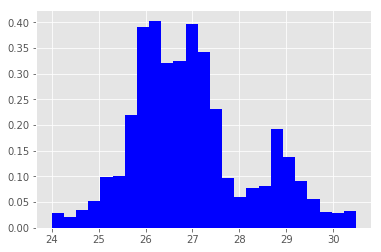

In [50]:
fig = plt.figure()
ax = plt.axes()
rectangles = ax.hist(chain[:,3],25,density=True,color='blue')

# Section 3
# In this section, we implement the MCMC parameter estimation of Jacobi Theta Function decline curve proposed 

In [51]:
#import the special function library
import mpmath as mp

#### Define Jacobi Theta Function

In [56]:
def Jacobi_theta(t,logQi,chi,eta):
    Qt = np.zeros(len(t))
    for i in range(len(t)):
        Qt[i] = logQi + np.log10(float(mp.jtheta(2,chi,np.exp(-eta*t[i]))))
    return Qt

In [105]:
logQi = 4
chi = 0.5
eta = 0.5
t_fine = np.linspace(0.01,11,119)
t = np.linspace(1,12,12)

#### Plot the initial guess using data, Jacobi Theta Function and Least Square Estimate

/Users/weibing/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.


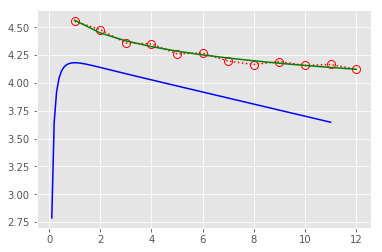

In [106]:
y_init =  Jacobi_theta(t_fine,logQi,chi,eta)
plt.plot(t_fine,y_init,'b-') # initial guess
plt.plot(t, data,fillstyle='none',**marker_style)
plt.plot(t, y_hat,'g-')

In [64]:
#### Define posterior probability function, and run MCMC to sample the parameters

In [60]:
def post(logQi,chi,eta,sigma,t,data):
    like = np.prod(np.exp(-np.power(Jacobi_theta(t,logQi,chi,eta)-data, 2)/sigma**2))
    return like # because constant uniform prior

In [62]:
logQi = data[0]
Niter = 30000
chain = np.zeros((Niter,3))
chain[0,0] = logQi# Initialize the chain with first guess
chain[0,1] = chi
chain[0,2] = eta

In [108]:
for ii in np.arange(Niter-1):
        if ii%10000 ==0:
            print('iteration {}'.format(ii))
        logQi    = chain[ii,0] 
        chi      = chain[ii,1] 
        eta      = chain[ii,2] 
        chi_p    = float(chi + np.random.normal(loc=0.0,scale=0.1,size=1))
        logQi_p  = float(logQi + np.random.normal(loc=0.0,scale=0.1,size=1))
        eta_p     = float(eta + np.random.normal(loc=0.0,scale=0.1,size=1))
        
        if chi_p < 0 or eta_p<0 or logQi_p > 7 or logQi_p< -2:
            chain[ii+1,:] = chain[ii,:]
        elif (post(logQi_p,chi_p,eta_p,sigma,t,data) / post(logQi,chi,eta,sigma,t,data)) > np.random.uniform():
            chain[ii+1,0] = logQi_p 
            chain[ii+1,1] = chi_p 
            chain[ii+1,2] = eta_p 
        else:
            chain[ii+1,:] = chain[ii,:]
print('Sampling finished at iteration {}'.format(Niter)) 

iteration 0


/Users/weibing/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.


iteration 10000
iteration 20000
Sampling finished at iteration 30000


[(4, 4.6)]

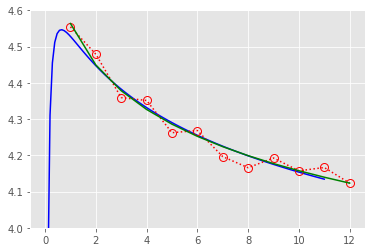

In [109]:
y_theta =  Jacobi_theta(t_fine,logQi,chi,eta)
fig = plt.figure()
aa = plt.axes()
plt.plot(t_fine,y_theta,'b-')
plt.plot(t,data,'ro',fillstyle='none',**marker_style)
plt.plot(t,y_hat,'g-')
aa.set(ylim = (4,4.6))

/Users/weibing/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.


[(3.5, 4.8), Text(0, 0.5, 'Oil Production'), Text(0.5, 0, 'months')]

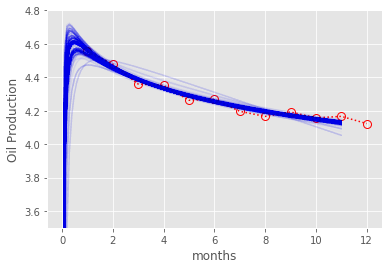

In [119]:
chains_to_plot=np.arange(1000)*9
fig = plt.figure()
aa = plt.axes()
aa.plot(t,data,'ro',fillstyle='none',**marker_style)
#aa.plot(y_hat,'g-')
kk=0
qq=np.zeros([len(chains_to_plot),len(t_fine)])
for ii in chains_to_plot-1:
    qq[kk,:]=Jacobi_theta(t_fine,chain[ii,0] ,chain[ii,1] ,chain[ii,2] )
    aa.plot(t_fine,qq[kk,:],color='blue',alpha=0.02)
    kk+=1
aa.set(ylim= (3.5,4.8), xlabel='months', ylabel='Oil Production')